<a href="https://colab.research.google.com/github/GiuliaLanzillotta/exercises/blob/master/Turning_my_sister_into_an_old_painting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Turning my sister into an old painting 
This notebook will explore the magic of GANs. <br>
We are going to refer to a particular GAN architecture : the **Cycle GAN**. 


> ### The goal? <br>Taking a picture of my beautiful sister and turn it into an old painting, to see how she would have looked like a few centuries ago. 


To do this we are going to need 3 things: 
  1. A picture of my sister 
  2. An implementation of *cycle GAN* 
  3. A rich enough collection of portaits of ladies from the past

### Let's get started!

The first thing we do is (1).

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

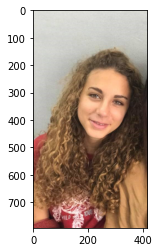

In [0]:
mysisterpic = "../mysister.jpg"
img = mpimg.imread(mysisterpic)
plt.imshow(img)

Now that (1) is done, we're going to jump to (3) before continuing to (2). 
## Building a dataset


The magic of the Cycle GAN model is that it doesn't need paired datasets. All it needs is an instance of the input set and an instance of the output set. To build the dataset we are going to download two sets of images from Google images, one with women paintings and one with actual women pictures. 

In [2]:
!git clone https://github.com/ultralytics/google-images-download

Cloning into 'google-images-download'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 710 (delta 0), reused 1 (delta 0), pack-reused 707
Receiving objects: 100% (710/710), 301.27 KiB | 6.15 MiB/s, done.
Resolving deltas: 100% (398/398), done.


In [0]:
## download selenium and the chrome driver 
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

In [0]:
%%bash 

#!/bin/bash 

# a script to download google images
cd google-images-download
python3 bing_scraper.py --search 'Women old painting oil' -o "paintings" --limit 200 --download --chromedriver chromedriver --color_type full-color --type face
python3 bing_scraper.py --search 'woman picture face photography portrait' -o "pictures" --limit 200 --download --chromedriver chromedriver --color_type full-color --type face

In [0]:
paintings_folder = "google-images-download/paintings/Women_old_painting_oil"
pictures_folder = "google-images-download/pictures/woman_picture_face_photography_portrait"

In [0]:
from os import listdir
from os.path import isfile, join
import os
paintings_files = [f for f in listdir(paintings_folder) if isfile(join(paintings_folder, f))]
pictures_files = [f for f in listdir(pictures_folder) if isfile(join(pictures_folder, f))]

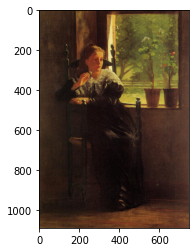

In [113]:
img = mpimg.imread(join(paintings_folder,paintings_files[66]))
plt.imshow(img)

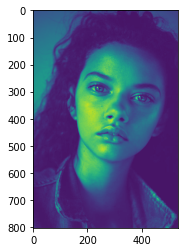

In [114]:
img = mpimg.imread(join(pictures_folder,pictures_files[66]))
plt.imshow(img)

Now that the data is actually here there's only one last step separating us from the actuall model coding. <br> 
We need to check for the corrupted files in the dataset and remove them before we get into training. 

In [118]:
for picture in pictures_files:
  try: 
    img = mpimg.imread(join(pictures_folder,picture))
  except Exception as e: 
    print("Removing ",picture)
    pictures_files.remove(picture)

Removing  135.1525891879-683036-peter-sjo-201640-unsplashjpg.png


In [0]:
for painting in paintings_files:
  try: 
    img = mpimg.imread(join(paintings_files,painting))
  except Exception as e: 
    print("Removing ",painting)
    paintings_files.remove(painting)

In [121]:
len(paintings_files) 

100

## The model : Cycle GAN

We'll be using Tensorflow 2 to implement the Cycle GAN as described in [this paper](https://arxiv.org/pdf/1703.10593.pdf).

### Data preprocessing


In [0]:
import tensorflow as tf

In [0]:
import numpy as np
from PIL import Image
from operator import itemgetter
from skimage.transform import resize

First we implement the data loading helper functions 


In [0]:
class DataHelper(object):
  def __init__(self, total, img_res=(512,512)):
    self.total = total # total number of images per category
    self.Xfolder = pictures_folder
    self.Yfolder = paintings_folder
    self.Xfiles = pictures_files
    self.Yfiles = paintings_files
    self.img_res = img_res # forcing a standard image resolution

  def generate_indices(self, test_split):
    """ Shuffles the input indices and splits them 
    in training and testing sets."""
    self.test_total = int(test_split*self.total)
    self.train_total = self.total - self.test_total
    # sample without replacement, aka shuffle
    indices = np.random.choice(a = range(0,self.total), 
                               size=self.total, 
                               replace=False) 
    # first test_split% of indices will go to test
    self.train_indices = indices[self.test_total:self.total]
    self.test_indices = indices[0:self.test_total]
    assert len(self.train_indices)==self.train_total \
        and len(self.test_indices)==self.test_total # just checking
    return self.train_indices, self.test_indices

  def load_and_preprocess(self, img_path, random_flip=False):
    img = mpimg.imread(img_path)
    # now some preprocessing 
    img = Image.fromarray((img).astype(np.uint8), 'RGB').resize(size=self.img_res)
    img = np.asarray(img)/127.5 - 1. #standardization
    #if random_flip : # increase/test model robustness 
    #  if np.random.random() > 0.5: img = np.fliplr(img)
    return img
  
  def de_preprocess(self, img):
    """Rolls back the preprocessing"""
    img = (np.asarray(img) +1)/2
    return img 

  def load_batch_of_train_images(self,
                                 test_split = 0.2,
                                 shuffling = False, 
                                 batch_size=1):
    """To use as a generator function during training.
        It goes through the dataset batch by batch 
        and loads (and preprocess) the images."""
    # You should use shuffling only at the beginning of the training
    if shuffling : self.generate_indices(test_split)
    # some math 
    n_batches = self.train_total // batch_size
    # and now the loading 
    for i in range(n_batches-1):
      batch_indices = self.train_indices[i*batch_size:(i+1)*batch_size]
      batch_X = itemgetter(*batch_indices)(self.Xfiles)
      batch_Y = itemgetter(*batch_indices)(self.Yfiles)
      if batch_size == 1: 
       test_X = [batch_X]
       test_Y = [batch_Y]
      imgs_X = np.array([self.load_and_preprocess(join(self.Xfolder, imgX)) for imgX in batch_X])
      imgs_Y = np.array([self.load_and_preprocess(join(self.Yfolder, imgY)) for imgY in batch_Y])
      yield imgs_X, imgs_Y

  def load_testing_image(self, size):
     """Loading size images from the test set (with random flipping)"""
     indices = np.random.choice(a = self.test_indices, 
                                size = size, 
                                replace = False)
     test_X = itemgetter(*indices)(self.Xfiles)
     test_Y = itemgetter(*indices)(self.Yfiles)
     if size == 1: 
       test_X = [test_X]
       test_Y = [test_Y]
     test_images_X = [self.load_and_preprocess(join(self.Xfolder, imgX), 
                                               random_flip=True) for imgX in test_X]
     test_images_Y = [self.load_and_preprocess(join(self.Yfolder, imgY), 
                                               random_flip=True) for imgY in test_Y]
     return (np.array(test_images_X), np.array(test_images_Y))

  ## the following 2 functions are just plotting helpers ##

  def plotQuartet(self, plot_images, epoch, save=True):
    """ Takes 2 pairs of images in [pre-post] ordering 
        and plot them in a grid. 
    """
    if save: os.makedirs('cycle_gan_images', exist_ok=True)
    titles = ['Original', 'Transformed']
    # We should first undo our preprocessing 
    # And finally we can plot
    fig, axs = plt.subplots(2, 2)
    cnt = 0
    for i in range(2):
        for j in range(2):
            axs[i,j].imshow(self.de_preprocess(plot_images[cnt]))
            axs[i, j].set_title(titles[j])
            axs[i,j].axis('off')
            cnt += 1
    if save: fig.savefig("cycle_gan_images/{}".format(epoch))
    plt.close()

  def plot20(self, images):
    """Plots the first 20 images of the list"""
    plt.figure(figsize=(10, 8))
    for i in range(20):
        img = plt.imread(images[i])
        plt.subplot(4, 5, i+1)
        plt.imshow(img)
        plt.title(img.shape)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

In [0]:
data_helper = DataHelper(total=200)

Let's test the plotting function and glance at our dataset.

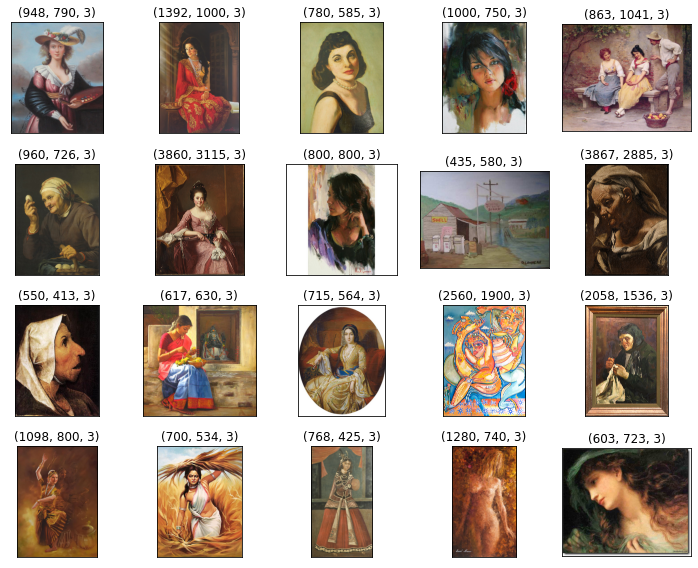

In [126]:
data_helper.plot20([(join(paintings_folder,paintings_files[i])) for i in range(20,40)])

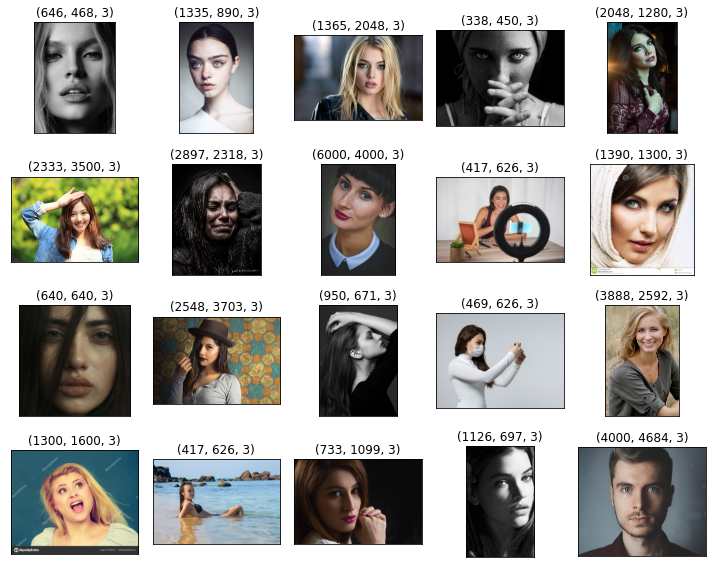

In [125]:
data_helper.plot20([(join(pictures_folder,pictures_files[i])) for i in range(20)])

As you probably have noticed, our dataset is far from perfect. But the majority of the data points look good.

Let's now have a look at the effects of preprocessing (below is the processed version of the above painting)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


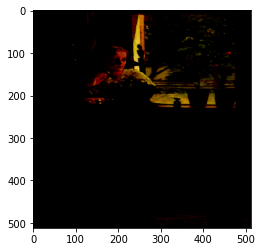

In [103]:
plt.imshow(data_helper.load_and_preprocess(join(paintings_folder,paintings_files[66])))

### Finally the CycleGAN class code 

In [0]:
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, LeakyReLU, Conv2DTranspose, Conv2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pandas as pd

Before diving into the code I want to give you an overall picture of the model we're going to build: 
![CycleGAN diagram](https://raw.githubusercontent.com/soobin3230/cycle-gan/master/png/cyclegan.png)
*(Figure 3 from the [paper](https://arxiv.org/pdf/1703.10593.pdf))*

Above is the diagram that is usually shown when explaining CycleGANs. <br>
Breaking the architecture into its main components we simply find: 
- 2 Discriminators (Dy and Dx) : one that works on the starting domain (usually X) and one that works on the end domain (usually Y). 
- 2 Generators (G and F): one generates images in the output domain (G) and one that learns to do exactly the inverse (F).

The cycleGAN idea can be easily applied to multiple data types (not just images), for example [here](https://github.com/yaushian/CycleGAN-sentiment-transfer) the same framework is used on text data.

If you work with images however, the **Discriminators** are usually CNNs. You can plug in an arbitrary complex CNN, or even a completely different network. The important thing is that it should be able to process images. Following the paper implementation, we are going to use PatchGANs as Discriminators (more on it later).

The **Generator** on the other hand has to be a kind of auto-encoder: it has to learn to extract relevant features from the input (in this case an image) - what we usually call *encoding*- and it then has to use this extracted knowledge to generate new samples - what we usually call *decoding*. 


#### Let's code!

In [0]:
class CycleGAN():
    def __init__(self, 
                 image_shape, 
                 cycle_lambda, 
                 total_images=200,
                 test_split = 0.2,
                 learning_rate=0.0002):
        ## Initializing training parameters 
        self.optimizer = Adam(learning_rate, beta_1=0.5 )
        ## Cycle Lambda is the penalization term for the 
        # CYCLE CONSISTENCY LOSS 
        self.cycle_lambda = cycle_lambda 
        ## Id lambda is the penalization term for the 
        # IDENTITY LOSS 
        self.id_lambda = 0.1 * self.cycle_lambda
        # checking the input 
        self.image_helper = DataHelper(total=total_images, 
                                       img_res=(image_shape[0],image_shape[1]))
        self.image_helper.generate_indices(test_split=test_split)
        self.img_shape = image_shape
        
        # Calculate the patches dimensions 
        # We want 2^4 = 16 patches in for each channel 
        # To know more read the PatchGAN part
        patch = int(self.img_shape[0] / 2**4) 
        self.disc_patch = (patch, patch, 1)

        ## Building and compiling discriminators 
        print("Build Discriminators...")
        self._Dx = self._build_discriminator_model()
        self._compile_discriminator_model(self._Dx)
        self._Dy = self._build_discriminator_model()
        self._compile_discriminator_model(self._Dy)
        ## Building and compiling generators
        print("Build Generators...")
        # G goes from X to Y
        self._G = self._build_generator_model()
        # F goes from Y to X
        self._F = self._build_generator_model()        
        ## Finally connecting the graph 
        print("Build GAN...")
        self._build_and_compile_gan()

    def _encoder_layer(self, input_layer, filters):
        """
        Builds a layer for the encoder. 
        Each encoder layer performs a convolution and a normalization.
        """
        layer = Conv2D(filters, kernel_size=4, strides=2, padding='same')(input_layer)
        layer = LeakyReLU(alpha=0.2)(layer)
        layer = tfa.layers.InstanceNormalization()(layer)
        return layer
        
    def _resnet_layer(self, input_layer, filters):
        """
        Builds a residual layer for the generator. 
        In a residual layer the input size does not change: 
        we hence use a stride of 1 and a padding of "same". 
        """
        layer = Conv2D(filters, kernel_size=4, strides=1, padding='same', activation='relu')(input_layer)
        return layer + input_layer

    def _decoder_layer(self, input_layer, filters, normalization=True):
        """
        Builds a layer for the decoder part of the generator.
        Here we need to inflate the input dimension.
        """
        initializer = tf.random_normal_initializer(0., 0.02)
        layer = Conv2DTranspose(filters, kernel_size=2, strides=2,
                                padding='same', kernel_initializer=initializer,
                                use_bias=False)(input_layer)
        layer = tfa.layers.InstanceNormalization()(layer)
        return layer
    
    def _build_generator_model(self):
        """
        Building the generator model function. 

        """
        generator_input = Input(shape=self.img_shape)
        
        print("Build Encoder...")
        encode_layer_1 = self._encoder_layer(generator_input, 32);
        encode_layer_2 = self._encoder_layer(encode_layer_1, 64);
        encode_layer_3 = self._encoder_layer(encode_layer_2, 128);
        encode_layer_4 = self._encoder_layer(encode_layer_3, 256);

        print("Build Transformer...")
        residual_layer_1 = self._resnet_layer(encode_layer_4, 256)
        residual_layer_2 = self._resnet_layer(residual_layer_1, 256)
        residual_layer_3 = self._resnet_layer(residual_layer_2, 256)
        residual_layer_4 = self._resnet_layer(residual_layer_3, 256)
        residual_layer_5 = self._resnet_layer(residual_layer_4, 256)
        residual_layer_6 = self._resnet_layer(residual_layer_5, 256)
        
        print("Build Decoder...")
        decode_layer1 = self._decoder_layer(residual_layer_6, 128)
        decode_layer2 = self._decoder_layer(decode_layer1, 64)
        decode_layer3 = self._decoder_layer(decode_layer2, 32)
        decode_layer4 = self._decoder_layer(decode_layer3, self.img_shape[2], 
                                            normalization=False)
        
        final_generator_model = Model(generator_input, decode_layer4)
        final_generator_model.summary()
        return final_generator_model
        
    def _build_discriminator_model(self):
        """
        Building a disciminator. 
        As a discriminator we use a CNN with 5 layers, 
        LeakyReLU activations, and instance normalizations.

        Instance Normalization normalizes your input values 
        across the channels based on their mean and variance.
        """ 
        # input layer 
        discriminator_input = Input(shape=self.img_shape)
        # ----- layer 1 -----
        discriminator_model = Conv2D(64, kernel_size=4, strides=2, padding='same')(discriminator_input)
        discriminator_model = LeakyReLU(alpha=0.2)(discriminator_model)
        # ----- layer 2 -----
        discriminator_model = Conv2D(128, kernel_size=4, strides=2, padding='same')(discriminator_model)
        discriminator_model = LeakyReLU(alpha=0.2)(discriminator_model)
        discriminator_model = tfa.layers.InstanceNormalization()(discriminator_model)
        # ----- layer 3 -----
        discriminator_model = Conv2D(256, kernel_size=4, strides=2, padding='same')(discriminator_model)
        discriminator_model = LeakyReLU(alpha=0.2)(discriminator_model)
        # isntance normalization 2
        discriminator_model = tfa.layers.InstanceNormalization()(discriminator_model)
        # ----- layer 4 -----
        discriminator_model = Conv2D(512, kernel_size=4, strides=2, padding='same')(discriminator_model)
        discriminator_model = LeakyReLU(alpha=0.2)(discriminator_model)
        # instance normalization 3
        discriminator_model = tfa.layers.InstanceNormalization()(discriminator_model)
        # ----- layer 5 -----        
        discriminator_model = Conv2D(1, kernel_size=4, strides=1, padding='same')(discriminator_model)
        return Model(discriminator_input, discriminator_model)
        
    def _compile_discriminator_model(self, model):
        model.compile(loss='binary_crossentropy',
                      optimizer=self.optimizer,
                      metrics=['accuracy'])
        model.summary()
    
    def _build_and_compile_gan(self):
        """
        Here we connect all the components in a unique graph. 
        """
        # ground truth
        imageX = Input(shape=self.img_shape)
        imageY = Input(shape=self.img_shape)
        # generate fake samples 
        fakeY = self._G(imageX)
        fakeX = self._F(imageY)
        # generate fake original images 
        # here we complete a cycle for each input image 
        reconstructedX = self._F(fakeY)
        reconstructedY = self._G(fakeX)
        # Terms for the identitz loss
        imageX_id = self._F(imageX)
        imageY_id = self._G(imageY)
        
        self._Dx.trainable = False
        self._Dy.trainable = False
        # Analyse the generated images 
        validX = self._Dx(fakeX)
        validY = self._Dy(fakeY)
        
        self.gan = Model(inputs=[imageX, imageY],
                         outputs=[validX, validY,
                                  reconstructedX, reconstructedY,
                                  imageX_id, imageY_id])
        # setting the losses and the respective weights 
        self.gan.compile(loss=['mse', 'mse', # L2 norm for the true-generated pair
                               'mae', 'mae', # L1 norm for the true-reconstructed pair
                               'mae', 'mae'], #L1 norm for the true-identity pair
                         loss_weights=[1, 1,
                                      self.cycle_lambda, self.cycle_lambda,
                                      self.id_lambda, self.id_lambda ],
                        optimizer=self.optimizer)
        
        self.gan.summary()

    ## TRAINING : 
    ## ---------------------------------------------------------------------- 

    def train(self, epochs, batch_size):
        
        # The labels to give the discriminators 
        real = np.ones((batch_size,) + self.disc_patch) # dimension = (batch_size, patch, patch, 1)
        fake = np.zeros((batch_size,) + self.disc_patch) # dimension = (batch_size, patch, patch, 1)
        
        history = []
        
        for epoch in range(epochs):
            for i, (imagesX, imagesY) in enumerate(self.image_helper.load_batch_of_train_images(batch_size = batch_size)):
                print ("-------------------------------------")
                print ("Epoch {} | Batch {}".format(epoch, i))

                print("Generate images...")
                fakeY = self._G.predict(imagesX)
                fakeX = self._F.predict(imagesY)

                print("Train Discriminators...")
                # training discriminator Dx
                discriminatorX_loss_real = self._Dx.train_on_batch(imagesX, real)
                discriminatorX_loss_fake = self._Dx.train_on_batch(fakeX, fake)
                discriminatorX_loss = 0.5 * np.add(discriminatorX_loss_real, discriminatorX_loss_fake)
                # training discriminator Dy
                discriminatorY_loss_real = self._Dy.train_on_batch(imagesY, real)
                discriminatorY_loss_fake = self._Dy.train_on_batch(fakeY, fake)
                discriminatorY_loss = 0.5 * np.add(discriminatorY_loss_real, discriminatorY_loss_fake)
                # average the losses 
                mean_discriminator_loss = 0.5 * np.add(discriminatorX_loss, discriminatorY_loss)
                
                print("Train Generators...")
                generator_loss = self.gan.train_on_batch([imagesX, imagesY],
                                                          [real, real,
                                                          imagesX, imagesY,
                                                          imagesX, imagesY])

                ## Final prints 
                print ("Discriminator loss: {}".format(mean_discriminator_loss[0]))
                print ("Generator loss: {}".format(generator_loss[0]))
                print ("---------------------------------------------------------")
                history.append({"D":mean_discriminator_loss[0],"G":generator_loss})
                
                if i%100 ==0:
                    self._save_images("{}_{}".format(epoch, i))
        # final plots
        self._plot_loss(history)


    ## UTILS : 
    ## ---------------------------------------------------------------------- 
    ## TODO: use Tensorboard for plotting history 

    def _save_images(self, epoch):
        """Util function to save quartets during training"""
        (img_X, img_Y) = self.image_helper.load_testing_image(size=1)
        fake_Y = self._G.predict(img_X)
        fake_X = self._F.predict(img_Y)
        plot_images = np.concatenate([img_X, fake_Y, img_Y, fake_X])
        self.image_helper.plotQuartet(plot_images, epoch, save=True)

    def _plot_loss(self, history):
        hist = pd.DataFrame(history)
        plt.figure(figsize=(20,5))
        for colnm in hist.columns:
            plt.plot(hist[colnm],label=colnm)
        plt.legend()
        plt.ylabel("loss")
        plt.xlabel("epochs")
        plt.show()

> Why using Instance Normalization ? 

As discussed in the paper [Instance Normalization: The Missing Ingredient for Fast Stylization](https://arxiv.org/abs/1607.08022) by Dmitry Ulyanov, Andrea Vedaldi, and Victor Lempitsky, replacing batch normalization with instance normalization significantly improves the quality of feedforward style transfer models.

> What architecture do we use for the discriminator? 

The discriminators proposed in the paper are PatchGANs, fully convolutional neural networks that look at a “patch” of the input image, and output the probability of the patch being “real”. This is both more computationally efficient than trying to look at the entire input image, and is also more effective — it allows the discriminator to focus on more surface-level features, like texture, which is often the sort of thing being changed in an image translation task.

> What architecture do we use for the generator? 

Below is a scheme of the architecture used by the generator (credits to [this beautiful post](https://towardsdatascience.com/cyclegan-learning-to-translate-images-without-paired-training-data-5b4e93862c8d)).<br>
Each CycleGAN generator has three sections: an encoder, a transformer, and a decoder. Our encoder is made of 4 encoding layers (each performing a convolution and a normalization). The transformer is where the magic happens: using *residual blocks* it learns to modify the style of the input image to match the desired output style.
Finally the decoder applies 2 transpose convolutions to the output of the transformer to inflate the image size back to the original input size. 
<br>
<br>

<img src="https://miro.medium.com/max/1400/1*PVBSmRcCz9xfw-fCNi_q5g.png" width="700"/>

> What are all those terms in the loss? 

The loss can be broken into 3 different terms: 
1. Mean squared error between the "fake" and "original" samples from each domain. This is the **"classic" GANs objective**, nothing new under the sun.
2. **The cycle consistency loss**: an L1 norm between the original and the "cycled" sample - aka the L1 norm between $x$ and $F(G(x))$, and between $y$ and $G(F(y))$. As you have probably noticed, this loss is pushing the two nets to be the inverse of one another.
3. **The identity loss**: an L1 norm between $x$ and $F(x)$ and between $y$ and $G(y)$. The idea here is to force the networks to map samples from their input domain to themselves. 

### Let's use this model!

In [128]:
image_resolution = (512,512,3)
tf.compat.v1.reset_default_graph()
myGAN = CycleGAN(image_shape=image_resolution, 
                 cycle_lambda=10.0, 
                 total_images=min(len(pictures_files), len(paintings_files)))

Build Discriminators...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 128)     0         
_________________________________________________________________
instance_normalization (Inst (None, 128, 128, 128)     256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6

In [0]:
myGAN.train(epochs=10, batch_size=4)

-------------------------------------
Epoch 0 | Batch 0
Generate images...
Train Discriminators...
